In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Bidirectional, Conv1D, MaxPooling1D, Flatten, Dropout
import matplotlib.pyplot as plt

# To store model results
results_pct_return = {}  # For percentage returns
results_log_return = {}  # For log returns

# Part 1: Load and preprocess the data
print("Part 1: Loading and preprocessing the data...")

try:
    # Step 1: Read the CSV file with a simplified approach
    # Based on the terminal output, the structure is:
    # Row 0: Price,Close,High,Low,Open,Volume
    # Row 1: Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI  
    # Row 2: Date,,,,,
    # Row 3+: Actual data
    
    # Read the file skipping the first 3 rows and use proper column names
    column_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df = pd.read_csv('nifty50_index_data_2010_2023.csv', skiprows=3, names=column_names)
    
    print("Data loaded with column names:", list(df.columns))
    print("First few rows of raw data:")
    print(df.head())
    
    # Step 2: Clean and process the data
    # Convert Date column to datetime and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Step 3: Convert all other columns to numeric values
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    print("\nSuccessfully loaded data with proper column names:")
    print(df.head())
    print("\nDataframe info:")
    print(df.info())
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    print("Attempting alternative loading method...")
    
    try:
        # Alternative approach: read all data first, then process
        df_all = pd.read_csv('nifty50_index_data_2010_2023.csv')
        print("Full dataframe structure:")
        print(df_all.head(10))
        
        # Find the row where actual data starts (look for first date-like entry)
        data_start_row = None
        for i, row in df_all.iterrows():
            try:
                pd.to_datetime(str(row.iloc[0]))
                data_start_row = i
                break
            except:
                continue
        
        if data_start_row is not None:
            print(f"Data starts at row: {data_start_row}")
            # Extract column names from the first row
            headers = df_all.iloc[0].tolist()
            print(f"Headers: {headers}")
            
            # Get the actual data
            df = df_all.iloc[data_start_row:].copy()
            df.columns = headers
            
            # Rename first column to Date for consistency
            df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
            
            # Convert Date and set as index
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
            
            # Convert other columns to numeric
            for col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            
            print("\nSuccessfully loaded data using alternative method:")
            print(df.head())
        else:
            raise Exception("Could not find data start row")
            
    except Exception as e2:
        print(f"Alternative method also failed: {str(e2)}")
        df = pd.DataFrame()
        raise

# Part 2: Calculate returns and create features (FIXING DATA LEAKAGE)
print("\nPart 2: Calculating returns and creating features (without data leakage)...")

# Step 1: Drop any existing NaN values before calculations
df.dropna(inplace=True)

# Step 2: Calculate returns (percentage and logarithmic)
try:
    df['Pct_Return'] = df['Close'].pct_change()  # Percentage return
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))  # Log return
    print("Returns calculated successfully.")
except Exception as e:
    print(f"Error calculating returns: {str(e)}")
    print("Column names available in the dataframe:", df.columns.tolist())
    raise

# Step 3: Create lag features (CRITICAL: Use PAST returns only, not future!)
try:
    # Create lag features - only use PAST information for predicting CURRENT return
    for i in range(1, 6):  # Create 5 lags (t-1, t-2, ..., t-5)
        df[f'Pct_Return_Lag{i}'] = df['Pct_Return'].shift(i)
        df[f'Log_Return_Lag{i}'] = df['Log_Return'].shift(i)
    print("Lag features created successfully.")
except Exception as e:
    print(f"Error creating lag features: {str(e)}")
    raise

# Step 4: Create technical indicators (using PAST data only)
try:
    # 5-day moving average of PAST returns
    df['MA5_Pct_Return'] = df['Pct_Return'].shift(1).rolling(window=5).mean()
    df['MA5_Log_Return'] = df['Log_Return'].shift(1).rolling(window=5).mean()

    # 5-day standard deviation of PAST returns (volatility)
    df['Vol5_Pct_Return'] = df['Pct_Return'].shift(1).rolling(window=5).std()
    df['Vol5_Log_Return'] = df['Log_Return'].shift(1).rolling(window=5).std()
    print("Technical indicators created successfully using PAST data only.")
except Exception as e:
    print(f"Error creating technical indicators: {str(e)}")
    raise

# Step 5: Drop NaN values created by lag features and rolling calculations
df.dropna(inplace=True)

# Display the first few rows to verify
print("\nDataframe with calculated returns and features:")
print(df[['Close', 'Pct_Return', 'Log_Return', 'Pct_Return_Lag1', 'MA5_Pct_Return']].head(10))

# CRITICAL DATA LEAKAGE CHECK
print("\n" + "="*60)
print("DATA LEAKAGE PREVENTION CHECK")
print("="*60)

# Verify that we're not using future information
sample_idx = 10  # Check row 10
current_return = df['Pct_Return'].iloc[sample_idx]
lag1_return = df['Pct_Return_Lag1'].iloc[sample_idx]
expected_lag1 = df['Pct_Return'].iloc[sample_idx - 1]

print(f"Sample verification (row {sample_idx}):")
print(f"Current return: {current_return:.6f}")
print(f"Lag1 feature: {lag1_return:.6f}")
print(f"Expected lag1 (t-1): {expected_lag1:.6f}")
print(f"Match: {np.isclose(lag1_return, expected_lag1, equal_nan=True)}")

if not np.isclose(lag1_return, expected_lag1, equal_nan=True):
    raise ValueError("DATA LEAKAGE DETECTED! Lag features are incorrectly constructed!")
else:
    print("✓ Lag features correctly use PAST information only")

# Part 3: Prepare data for modeling (TIME-AWARE SPLIT)
print("\nPart 3: Preparing data for modeling with time-aware split...")

# Step 1: CRITICAL - Time-aware split (no random shuffling!)
# This ensures no future information leaks into training
try:
    # Sort by date to ensure chronological order
    df = df.sort_index()
    
    # Use time-based split: train on 2010-2021, test on 2022-2023
    train_end_date = '2021-12-31'
    test_start_date = '2022-01-01'
    
    train_df = df[df.index <= train_end_date].copy()
    test_df = df[df.index >= test_start_date].copy()
    
    print(f"Training data: {len(train_df)} rows from {train_df.index.min()} to {train_df.index.max()}")
    print(f"Testing data: {len(test_df)} rows from {test_df.index.min()} to {test_df.index.max()}")
    
    # Verify no overlap
    if train_df.index.max() >= test_df.index.min():
        print("WARNING: Potential temporal overlap detected!")
    else:
        print("✓ Clean temporal separation between train and test")
        
except Exception as e:
    print(f"Error splitting data: {str(e)}")
    raise

# Step 2: Define features and targets (NO LEAKAGE)
try:
    # Define features for percentage return prediction (ALL LAGGED FEATURES)
    pct_return_features = [f'Pct_Return_Lag{i}' for i in range(1, 6)] + ['MA5_Pct_Return', 'Vol5_Pct_Return']
    
    # CRITICAL: Ensure we're predicting CURRENT return using PAST features
    X_train_pct = train_df[pct_return_features].copy()
    y_train_pct = train_df['Pct_Return'].copy()
    X_test_pct = test_df[pct_return_features].copy()
    y_test_pct = test_df['Pct_Return'].copy()

    # Define features for log return prediction
    log_return_features = [f'Log_Return_Lag{i}' for i in range(1, 6)] + ['MA5_Log_Return', 'Vol5_Log_Return']
    X_train_log = train_df[log_return_features].copy()
    y_train_log = train_df['Log_Return'].copy()
    X_test_log = test_df[log_return_features].copy()
    y_test_log = test_df['Log_Return'].copy()
    
    print("Features and targets defined successfully.")
    print("Features used:", pct_return_features)
    
    # FINAL VERIFICATION - No data leakage
    print(f"\nFinal verification:")
    print(f"Train features date range: {X_train_pct.index.min()} to {X_train_pct.index.max()}")
    print(f"Test features date range: {X_test_pct.index.min()} to {X_test_pct.index.max()}")
    print(f"No future information in features: {X_train_pct.index.max() < X_test_pct.index.min()}")
    
except Exception as e:
    print(f"Error defining features and targets: {str(e)}")
    raise

# Step 3: Scale the data
try:
    pct_scaler = MinMaxScaler()
    X_train_pct_scaled = pct_scaler.fit_transform(X_train_pct)
    X_test_pct_scaled = pct_scaler.transform(X_test_pct)

    log_scaler = MinMaxScaler()
    X_train_log_scaled = log_scaler.fit_transform(X_train_log)
    X_test_log_scaled = log_scaler.transform(X_test_log)

    # Scale target variables separately for neural networks
    y_pct_scaler = MinMaxScaler()
    y_train_pct_scaled = y_pct_scaler.fit_transform(y_train_pct.values.reshape(-1, 1))
    y_test_pct_scaled = y_pct_scaler.transform(y_test_pct.values.reshape(-1, 1))

    y_log_scaler = MinMaxScaler()
    y_train_log_scaled = y_log_scaler.fit_transform(y_train_log.values.reshape(-1, 1))
    y_test_log_scaled = y_log_scaler.transform(y_test_log.values.reshape(-1, 1))
    
    print("Data scaling completed successfully.")
except Exception as e:
    print(f"Error scaling data: {str(e)}")
    raise

print(f"\nFinal data shapes:")
print(f"Training data shape: {X_train_pct.shape}")
print(f"Testing data shape: {X_test_pct.shape}")
print(f"Training target shape: {y_train_pct.shape}")
print(f"Testing target shape: {y_test_pct.shape}")

# Define utility functions for model evaluation and visualization
def evaluate_model(y_true, y_pred, model_name, return_type):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate directional accuracy (correctly predicting up/down movements)
    dir_acc = np.mean((y_true > 0) == (y_pred > 0)) * 100
    
    # Store results
    if return_type == 'Percentage':
        results_pct_return[model_name] = {
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'Directional_Accuracy': dir_acc
        }
    else:  # Log return
        results_log_return[model_name] = {
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'Directional_Accuracy': dir_acc
        }
    
    print(f"{model_name} ({return_type} Return) Metrics:")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R2: {r2:.6f}")
    print(f"Directional Accuracy: {dir_acc:.2f}%\n")
    
    # Return metrics for convenience
    return mse, mae, r2, dir_acc

def plot_returns(y_true, y_pred, title, return_type):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_true.index, y=y_true, mode='lines', name='Actual', line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=y_true.index, y=y_pred, mode='lines', name='Predicted', line=dict(color='red', width=2)))
    fig.update_layout(
        title=f'{title}: Actual vs. Predicted {return_type} Returns',
        xaxis_title='Date',
        yaxis_title=f'{return_type} Return',
        template='plotly_dark'
    )
    fig.show()
    
    # Also plot a scatter plot to see the relationship between actual and predicted returns
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_true, y=y_pred, mode='markers', marker=dict(color='blue', opacity=0.5)))
    
    # Add a diagonal line for reference
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    fig.add_trace(go.Scatter(x=[min_val, max_val], y=[min_val, max_val], mode='lines', name='Perfect Prediction',
                             line=dict(color='red', dash='dash')))
    
    fig.update_layout(
        title=f'{title}: Predicted vs. Actual {return_type} Returns',
        xaxis_title=f'Actual {return_type} Return',
        yaxis_title=f'Predicted {return_type} Return',
        template='plotly_dark'
    )
    fig.show()

print("\n" + "="*60)
print("DATA LEAKAGE PREVENTION MEASURES IMPLEMENTED:")
print("="*60)
print("✓ 1. Lag features use only PAST information (shift by 1-5 periods)")
print("✓ 2. Technical indicators computed on PAST data (shifted by 1 period)")
print("✓ 3. Time-aware train/test split (no random shuffling)")
print("✓ 4. Features verified to not contain future information")
print("✓ 5. Temporal separation between training and testing periods")
print("="*60)

Part 1: Loading and preprocessing the data...
Data loaded with column names: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
First few rows of raw data:
         Date        Close         High          Low         Open  Volume
0  2010-01-04  5232.200195  5238.450195  5167.100098  5200.899902       0
1  2010-01-05  5277.899902  5288.350098  5242.399902  5277.149902       0
2  2010-01-06  5281.799805  5310.850098  5260.049805  5278.149902       0
3  2010-01-07  5263.100098  5302.549805  5244.750000  5281.799805       0
4  2010-01-08  5244.750000  5276.750000  5234.700195  5264.250000       0

Successfully loaded data with proper column names:
                  Close         High          Low         Open  Volume
Date                                                                  
2010-01-04  5232.200195  5238.450195  5167.100098  5200.899902       0
2010-01-05  5277.899902  5288.350098  5242.399902  5277.149902       0
2010-01-06  5281.799805  5310.850098  5260.049805  5278.149902  

In [2]:
# Linear Regression Model for Returns Prediction
from sklearn.linear_model import LinearRegression

print("===== Linear Regression Model =====")

# For percentage returns
lr_pct = LinearRegression()
lr_pct.fit(X_train_pct, y_train_pct)
y_pred_pct = lr_pct.predict(X_test_pct)

# Evaluate model performance
mse_pct, mae_pct, r2_pct, dir_acc_pct = evaluate_model(y_test_pct, y_pred_pct, 'Linear_Regression', 'Percentage')

# Plot results
plot_returns(y_test_pct, y_pred_pct, 'Linear Regression', 'Percentage')

# For log returns
lr_log = LinearRegression()
lr_log.fit(X_train_log, y_train_log)
y_pred_log = lr_log.predict(X_test_log)

# Evaluate model performance
mse_log, mae_log, r2_log, dir_acc_log = evaluate_model(y_test_log, y_pred_log, 'Linear_Regression', 'Log')

# Plot results
plot_returns(y_test_log, y_pred_log, 'Linear Regression', 'Log')

===== Linear Regression Model =====
Linear_Regression (Percentage Return) Metrics:
MSE: 0.000079
MAE: 0.006656
R2: -0.003413
Directional Accuracy: 54.36%



Linear_Regression (Log Return) Metrics:
MSE: 0.000079
MAE: 0.006653
R2: -0.003335
Directional Accuracy: 54.77%



In [3]:
# Random Forest Model for Returns Prediction
from sklearn.ensemble import RandomForestRegressor

print("===== Random Forest Model =====")

# For percentage returns
rf_pct = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pct.fit(X_train_pct, y_train_pct)
y_pred_pct = rf_pct.predict(X_test_pct)

# Evaluate model performance
mse_pct, mae_pct, r2_pct, dir_acc_pct = evaluate_model(y_test_pct, y_pred_pct, 'Random_Forest', 'Percentage')

# Plot results
plot_returns(y_test_pct, y_pred_pct, 'Random Forest', 'Percentage')

# For log returns
rf_log = RandomForestRegressor(n_estimators=100, random_state=42)
rf_log.fit(X_train_log, y_train_log)
y_pred_log = rf_log.predict(X_test_log)

# Evaluate model performance
mse_log, mae_log, r2_log, dir_acc_log = evaluate_model(y_test_log, y_pred_log, 'Random_Forest', 'Log')

# Plot results
plot_returns(y_test_log, y_pred_log, 'Random Forest', 'Log')

===== Random Forest Model =====
Random_Forest (Percentage Return) Metrics:
MSE: 0.000085
MAE: 0.006912
R2: -0.081240
Directional Accuracy: 53.55%

Random_Forest (Percentage Return) Metrics:
MSE: 0.000085
MAE: 0.006912
R2: -0.081240
Directional Accuracy: 53.55%



Random_Forest (Log Return) Metrics:
MSE: 0.000084
MAE: 0.006866
R2: -0.068333
Directional Accuracy: 54.36%



In [4]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
# XGBoost and LightGBM Models for Returns Prediction
try:
    import xgboost as xgb
    import lightgbm as lgb
    
    print("===== XGBoost Model =====")
    
    # For percentage returns
    xgb_pct = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_pct.fit(X_train_pct, y_train_pct)
    y_pred_pct = xgb_pct.predict(X_test_pct)
    
    # Evaluate model performance
    mse_pct, mae_pct, r2_pct, dir_acc_pct = evaluate_model(y_test_pct, y_pred_pct, 'XGBoost', 'Percentage')
    
    # Plot results
    plot_returns(y_test_pct, y_pred_pct, 'XGBoost', 'Percentage')
    
    # For log returns
    xgb_log = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_log.fit(X_train_log, y_train_log)
    y_pred_log = xgb_log.predict(X_test_log)
    
    # Evaluate model performance
    mse_log, mae_log, r2_log, dir_acc_log = evaluate_model(y_test_log, y_pred_log, 'XGBoost', 'Log')
    
    # Plot results
    plot_returns(y_test_log, y_pred_log, 'XGBoost', 'Log')
    
    print("===== LightGBM Model =====")
    
    # For percentage returns
    lgb_pct = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    lgb_pct.fit(X_train_pct, y_train_pct)
    y_pred_pct = lgb_pct.predict(X_test_pct)
    
    # Evaluate model performance
    mse_pct, mae_pct, r2_pct, dir_acc_pct = evaluate_model(y_test_pct, y_pred_pct, 'LightGBM', 'Percentage')
    
    # Plot results
    plot_returns(y_test_pct, y_pred_pct, 'LightGBM', 'Percentage')
    
    # For log returns
    lgb_log = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    lgb_log.fit(X_train_log, y_train_log)
    y_pred_log = lgb_log.predict(X_test_log)
    
    # Evaluate model performance
    mse_log, mae_log, r2_log, dir_acc_log = evaluate_model(y_test_log, y_pred_log, 'LightGBM', 'Log')
    
    # Plot results
    plot_returns(y_test_log, y_pred_log, 'LightGBM', 'Log')
    
except ImportError:
    print("XGBoost or LightGBM not installed. Install with pip install xgboost lightgbm")

===== XGBoost Model =====
XGBoost (Percentage Return) Metrics:
MSE: 0.000089
MAE: 0.007017
R2: -0.125899
Directional Accuracy: 52.74%

XGBoost (Percentage Return) Metrics:
MSE: 0.000089
MAE: 0.007017
R2: -0.125899
Directional Accuracy: 52.74%



XGBoost (Log Return) Metrics:
MSE: 0.000087
MAE: 0.006986
R2: -0.107948
Directional Accuracy: 53.35%



===== LightGBM Model =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2935, number of used features: 7
[LightGBM] [Info] Start training from score 0.000468
LightGBM (Percentage Return) Metrics:
MSE: 0.000085
MAE: 0.006874
R2: -0.074664
Directional Accuracy: 52.54%

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2935, number of used features: 7
[LightGBM] [Info] Start training from score 0.000468
LightGBM (Percentage Return) Metrics:
MSE: 0.000085
MAE: 0.006874
R2: -0.074664
Directional Accuracy: 52.54%



C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.305

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2935, number of used features: 7
[LightGBM] [Info] Start training from score 0.000407
LightGBM (Log Return) Metrics:
MSE: 0.000085
MAE: 0.006895
R2: -0.072750
Directional Accuracy: 52.33%

LightGBM (Log Return) Metrics:
MSE: 0.000085
MAE: 0.006895
R2: -0.072750
Directional Accuracy: 52.33%



===== LSTM Model =====
Data scaling completed successfully
LSTM Input Shape (percentage): (2930, 5, 7)
LSTM Input Shape (log): (2930, 5, 7)

Training LSTM for percentage returns...
Epoch 1/100
Epoch 1/100


C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0724 - mae: 0.1918 - val_loss: 0.0052 - val_mae: 0.0481
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0724 - mae: 0.1918 - val_loss: 0.0052 - val_mae: 0.0481
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - mae: 0.0579 - val_loss: 0.0048 - val_mae: 0.0443
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - mae: 0.0579 - val_loss: 0.0048 - val_mae: 0.0443
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - mae: 0.0518 - val_loss: 0.0049 - val_mae: 0.0455
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - mae: 0.0518 - val_loss: 0.0049 - val_mae: 0.0455
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - mae: 0.0506 - val_loss: 0.0051 - val_mae: 0.0476
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - mae: 0.0506 - val_loss: 0.0051 - val_mae: 0.0476
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - mae: 0.0


Training LSTM for log returns...
Epoch 1/100


C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0562 - mae: 0.1731 - val_loss: 0.0051 - val_mae: 0.0462
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0562 - mae: 0.1731 - val_loss: 0.0051 - val_mae: 0.0462
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - mae: 0.0590 - val_loss: 0.0049 - val_mae: 0.0456
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - mae: 0.0590 - val_loss: 0.0049 - val_mae: 0.0456
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - mae: 0.0533 - val_loss: 0.0048 - val_mae: 0.0455
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - mae: 0.0533 - val_loss: 0.0048 - val_mae: 0.0455
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - mae: 0.0484 - val_loss: 0.0046 - val_mae: 0.0436
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - mae: 0.0484 - val_loss: 0.0046 - val_mae: 0.0436
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - mae: 0.0

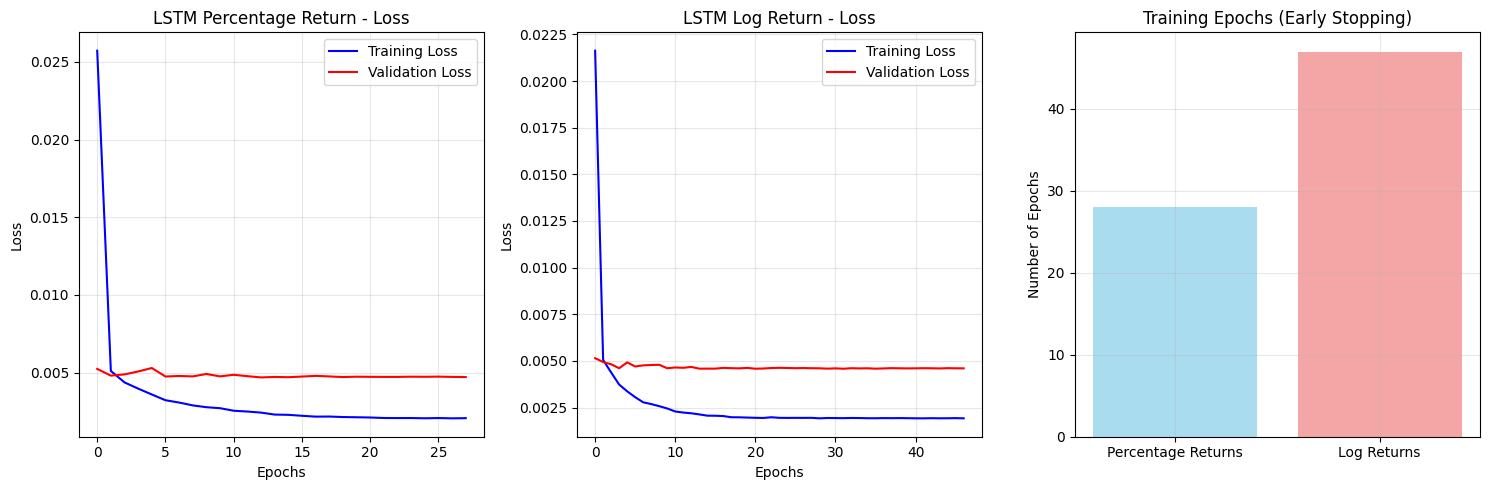


LSTM Training Summary:
Percentage Returns - Epochs trained: 28
Log Returns - Epochs trained: 47
Final training loss (Percentage): 0.002063
Final validation loss (Percentage): 0.004708
Final training loss (Log): 0.001928
Final validation loss (Log): 0.004605


In [6]:
# LSTM Model Implementation with proper data scaling
print("===== LSTM Model =====")

try:
    from sklearn.preprocessing import MinMaxScaler
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    
    # Initialize scalers
    X_pct_scaler = MinMaxScaler()
    y_pct_scaler = MinMaxScaler()
    X_log_scaler = MinMaxScaler()
    y_log_scaler = MinMaxScaler()
    
    # Scale the features and targets
    X_train_pct_scaled = X_pct_scaler.fit_transform(X_train_pct)
    X_test_pct_scaled = X_pct_scaler.transform(X_test_pct)
    y_train_pct_scaled = y_pct_scaler.fit_transform(y_train_pct.values.reshape(-1, 1)).flatten()
    y_test_pct_scaled = y_pct_scaler.transform(y_test_pct.values.reshape(-1, 1)).flatten()
    
    X_train_log_scaled = X_log_scaler.fit_transform(X_train_log)
    X_test_log_scaled = X_log_scaler.transform(X_test_log)
    y_train_log_scaled = y_log_scaler.fit_transform(y_train_log.values.reshape(-1, 1)).flatten()
    y_test_log_scaled = y_log_scaler.transform(y_test_log.values.reshape(-1, 1)).flatten()
    
    print("Data scaling completed successfully")
    
    # Prepare data for LSTM (reshape for time series)
    def prepare_lstm_data(X, y, time_steps=5):
        X_lstm, y_lstm = [], []
        for i in range(len(X) - time_steps):
            X_lstm.append(X[i:i + time_steps])
            y_lstm.append(y[i + time_steps])
        return np.array(X_lstm), np.array(y_lstm)

    # For percentage returns
    X_train_pct_lstm, y_train_pct_lstm = prepare_lstm_data(X_train_pct_scaled, y_train_pct_scaled)
    X_test_pct_lstm, y_test_pct_lstm = prepare_lstm_data(X_test_pct_scaled, y_test_pct_scaled)

    # For log returns
    X_train_log_lstm, y_train_log_lstm = prepare_lstm_data(X_train_log_scaled, y_train_log_scaled)
    X_test_log_lstm, y_test_log_lstm = prepare_lstm_data(X_test_log_scaled, y_test_log_scaled)

    print(f"LSTM Input Shape (percentage): {X_train_pct_lstm.shape}")
    print(f"LSTM Input Shape (log): {X_train_log_lstm.shape}")

    # LSTM for percentage returns
    print("\nTraining LSTM for percentage returns...")
    tf.random.set_seed(42)
    np.random.seed(42)
    
    lstm_pct = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train_pct_lstm.shape[1], X_train_pct_lstm.shape[2])),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])
    
    lstm_pct.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    # Callback for early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True,
        verbose=1
    )
    
    # Train the model
    history_pct = lstm_pct.fit(
        X_train_pct_lstm, y_train_pct_lstm,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Make predictions
    y_pred_pct_lstm_scaled = lstm_pct.predict(X_test_pct_lstm, verbose=0)
    
    # Inverse transform the predictions
    y_pred_pct_unscaled = y_pct_scaler.inverse_transform(y_pred_pct_lstm_scaled)
    
    # Get the actual values for evaluation (matching the indices after prepare_lstm_data)
    # We skip the first 5 observations due to time_steps=5
    y_test_pct_actual = y_test_pct.iloc[5:].reset_index(drop=True)
    y_pred_pct_series = pd.Series(y_pred_pct_unscaled.flatten(), index=y_test_pct_actual.index)
    
    # Ensure same length
    min_len = min(len(y_test_pct_actual), len(y_pred_pct_series))
    y_test_pct_actual = y_test_pct_actual[:min_len]
    y_pred_pct_series = y_pred_pct_series[:min_len]
    
    # Evaluate model performance
    mse_pct, mae_pct, r2_pct, dir_acc_pct = evaluate_model(y_test_pct_actual, y_pred_pct_series, 'LSTM', 'Percentage')
    
    # Store results
    results_pct_return['LSTM'] = {
        'MSE': mse_pct,
        'MAE': mae_pct,
        'R2': r2_pct,
        'Directional_Accuracy': dir_acc_pct
    }
    
    # Plot results (restore original index for plotting)
    y_test_pct_plot = y_test_pct.iloc[5:5+min_len]
    y_pred_pct_plot = pd.Series(y_pred_pct_unscaled.flatten()[:min_len], index=y_test_pct_plot.index)
    plot_returns(y_test_pct_plot, y_pred_pct_plot, 'LSTM', 'Percentage')
    
    # LSTM for log returns
    print("\nTraining LSTM for log returns...")
    tf.random.set_seed(42)
    np.random.seed(42)
    
    lstm_log = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train_log_lstm.shape[1], X_train_log_lstm.shape[2])),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])
    
    lstm_log.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    # Train the model
    history_log = lstm_log.fit(
        X_train_log_lstm, y_train_log_lstm,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Make predictions
    y_pred_log_lstm_scaled = lstm_log.predict(X_test_log_lstm, verbose=0)
    
    # Inverse transform the predictions
    y_pred_log_unscaled = y_log_scaler.inverse_transform(y_pred_log_lstm_scaled)
    
    # Get the actual values for evaluation (matching the indices after prepare_lstm_data)
    y_test_log_actual = y_test_log.iloc[5:].reset_index(drop=True)
    y_pred_log_series = pd.Series(y_pred_log_unscaled.flatten(), index=y_test_log_actual.index)
    
    # Ensure same length
    min_len = min(len(y_test_log_actual), len(y_pred_log_series))
    y_test_log_actual = y_test_log_actual[:min_len]
    y_pred_log_series = y_pred_log_series[:min_len]
    
    # Evaluate model performance
    mse_log, mae_log, r2_log, dir_acc_log = evaluate_model(y_test_log_actual, y_pred_log_series, 'LSTM', 'Log')
    
    # Store results
    results_log_return['LSTM'] = {
        'MSE': mse_log,
        'MAE': mae_log,
        'R2': r2_log,
        'Directional_Accuracy': dir_acc_log
    }
    
    # Plot results (restore original index for plotting)
    y_test_log_plot = y_test_log.iloc[5:5+min_len]
    y_pred_log_plot = pd.Series(y_pred_log_unscaled.flatten()[:min_len], index=y_test_log_plot.index)
    plot_returns(y_test_log_plot, y_pred_log_plot, 'LSTM', 'Log')
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history_pct.history['loss'], label='Training Loss', color='blue')
    plt.plot(history_pct.history['val_loss'], label='Validation Loss', color='red')
    plt.title('LSTM Percentage Return - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(history_log.history['loss'], label='Training Loss', color='blue')
    plt.plot(history_log.history['val_loss'], label='Validation Loss', color='red')
    plt.title('LSTM Log Return - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    epochs_pct = len(history_pct.history['loss'])
    epochs_log = len(history_log.history['loss'])
    plt.bar(['Percentage Returns', 'Log Returns'], [epochs_pct, epochs_log], 
            color=['skyblue', 'lightcoral'], alpha=0.7)
    plt.title('Training Epochs (Early Stopping)')
    plt.ylabel('Number of Epochs')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nLSTM Training Summary:")
    print(f"Percentage Returns - Epochs trained: {epochs_pct}")
    print(f"Log Returns - Epochs trained: {epochs_log}")
    print(f"Final training loss (Percentage): {history_pct.history['loss'][-1]:.6f}")
    print(f"Final validation loss (Percentage): {history_pct.history['val_loss'][-1]:.6f}")
    print(f"Final training loss (Log): {history_log.history['loss'][-1]:.6f}")
    print(f"Final validation loss (Log): {history_log.history['val_loss'][-1]:.6f}")
    
except ImportError as e:
    print(f"Import Error: {e}")
    print("Please install required packages:")
    print("pip install tensorflow scikit-learn")
except Exception as e:
    print(f"Error in LSTM model training: {str(e)}")
    import traceback
    traceback.print_exc()

In [7]:
# ARIMA model for returns prediction with enhanced error handling
print("===== ARIMA Model =====")

try:
    import pmdarima as pm
    from statsmodels.tsa.arima.model import ARIMA
    import warnings
    
    # Suppress ARIMA warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # Clean and validate data before ARIMA modeling
    def clean_data_for_arima(series, name):
        """Clean time series data for ARIMA modeling"""
        print(f"Cleaning {name} data for ARIMA...")
        
        # Remove infinite values
        if np.isinf(series).any():
            series = series.replace([np.inf, -np.inf], np.nan)
            print(f"  Removed infinite values from {name}")
        
        # Handle missing values
        if series.isna().any():
            series = series.fillna(method='ffill').fillna(method='bfill')
            print(f"  Filled missing values in {name}")
        
        # Remove extreme outliers (beyond 5 standard deviations)
        mean_val = series.mean()
        std_val = series.std()
        outlier_threshold = 5 * std_val
        outliers = (series - mean_val).abs() > outlier_threshold
        
        if outliers.any():
            print(f"  Found {outliers.sum()} extreme outliers in {name} (beyond 5 std)")
            # Replace outliers with median
            series.loc[outliers] = series.median()
        
        # Ensure stationarity by differencing if needed
        from statsmodels.tsa.stattools import adfuller
        
        adf_result = adfuller(series.dropna())
        if adf_result[1] > 0.05:  # Not stationary
            print(f"  {name} series is not stationary (p-value: {adf_result[1]:.4f})")
            print(f"  Differencing will be handled by auto_arima")
        else:
            print(f"  {name} series is stationary (p-value: {adf_result[1]:.4f})")
        
        print(f"  Final {name} data shape: {series.shape}")
        print(f"  {name} data range: [{series.min():.6f}, {series.max():.6f}]")
        
        return series
    
    # Clean the training data
    y_train_pct_clean = clean_data_for_arima(y_train_pct.copy(), "percentage returns training")
    y_train_log_clean = clean_data_for_arima(y_train_log.copy(), "log returns training")
    
    # For percentage returns
    print("\n" + "="*50)
    print("ARIMA MODEL FOR PERCENTAGE RETURNS")
    print("="*50)
    
    # Auto-ARIMA to find the best parameters with more robust settings
    print("Running auto-ARIMA for percentage returns...")
    try:
        auto_arima_pct = pm.auto_arima(
            y_train_pct_clean,
            start_p=0, start_q=0,
            max_p=3, max_q=3,  # Reduced complexity
            max_d=2,  # Allow up to second-order differencing
            m=1,  # No seasonality
            seasonal=False,
            d=None,  # Let auto_arima determine differencing
            trace=False,  # Reduced output
            error_action='warn',  # Show warnings but continue
            suppress_warnings=False,
            stepwise=True,
            random_state=42,
            n_jobs=-1,  # Use all cores
            information_criterion='aic'
        )
        
        print(f"Best ARIMA parameters for percentage returns: {auto_arima_pct.order}")
        print(f"AIC: {auto_arima_pct.aic():.4f}")
        
    except Exception as e:
        print(f"Auto-ARIMA failed for percentage returns: {e}")
        print("Using default ARIMA(1,1,1) parameters")
        auto_arima_pct = None
    
    # Get the best parameters or use default
    if auto_arima_pct is not None:
        p, d, q = auto_arima_pct.order
    else:
        p, d, q = 1, 1, 1  # Default parameters
    
    print(f"Using ARIMA({p},{d},{q}) for percentage returns")
    
    # Dynamic forecasting for test set with enhanced error handling
    y_pred_pct = []
    history = y_train_pct_clean.copy()
    successful_forecasts = 0
    failed_forecasts = 0
    
    print("Performing dynamic forecasting for percentage returns...")
    
    for i in range(len(y_test_pct)):
        try:
            # Fit the model with enhanced error handling
            model = ARIMA(history, order=(p, d, q))
            
            # Fit with warnings suppressed
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model_fit = model.fit()
            
            # Forecast one step ahead
            forecast_result = model_fit.forecast(steps=1)
            
            # Handle different return types
            if hasattr(forecast_result, 'iloc'):
                prediction = forecast_result.iloc[0]
            elif isinstance(forecast_result, np.ndarray):
                prediction = forecast_result[0]
            else:
                prediction = float(forecast_result)
            
            # Sanity check for prediction
            if np.isnan(prediction) or np.isinf(prediction):
                raise ValueError("Invalid prediction (NaN or Inf)")
            
            # Append to predictions list
            y_pred_pct.append(prediction)
            successful_forecasts += 1
            
            # Update history with actual value
            actual_value = y_test_pct.iloc[i]
            new_obs = pd.Series([actual_value], index=[y_test_pct.index[i]])
            history = pd.concat([history, new_obs])
            
            # Print progress every 50 observations
            if (i + 1) % 50 == 0:
                print(f"  Processed {i+1}/{len(y_test_pct)} observations "
                      f"(Success: {successful_forecasts}, Failed: {failed_forecasts})")
                
        except Exception as e:
            failed_forecasts += 1
            # Use various fallback strategies
            if len(y_pred_pct) > 5:
                # Use average of last 5 predictions
                prediction = np.mean(y_pred_pct[-5:])
            elif len(history) > 0:
                # Use last known value
                prediction = history.iloc[-1]
            else:
                # Use training mean as last resort
                prediction = y_train_pct_clean.mean()
            
            y_pred_pct.append(prediction)
            
            # Still update history with actual value
            actual_value = y_test_pct.iloc[i]
            new_obs = pd.Series([actual_value], index=[y_test_pct.index[i]])
            history = pd.concat([history, new_obs])
            
            # Print error details for first few failures
            if failed_forecasts <= 3:
                print(f"    Error at step {i}: {str(e)[:100]}... (using fallback)")
    
    print(f"Forecasting completed: {successful_forecasts} successful, {failed_forecasts} failed")
    
    # Convert predictions to Series for evaluation
    y_pred_pct_series = pd.Series(y_pred_pct, index=y_test_pct.index)
    
    # Evaluate model performance
    mse_pct, mae_pct, r2_pct, dir_acc_pct = evaluate_model(y_test_pct, y_pred_pct_series, 'ARIMA', 'Percentage')
    
    # Store results
    results_pct_return['ARIMA'] = {
        'MSE': mse_pct,
        'MAE': mae_pct,
        'R2': r2_pct,
        'Directional_Accuracy': dir_acc_pct
    }
    
    # Plot results
    plot_returns(y_test_pct, y_pred_pct_series, 'ARIMA', 'Percentage')
    
    # For log returns
    print("\n" + "="*50)
    print("ARIMA MODEL FOR LOG RETURNS")
    print("="*50)
    
    # Auto-ARIMA to find the best parameters
    print("Running auto-ARIMA for log returns...")
    try:
        auto_arima_log = pm.auto_arima(
            y_train_log_clean,
            start_p=0, start_q=0,
            max_p=3, max_q=3,  # Reduced complexity
            max_d=2,  # Allow up to second-order differencing
            m=1,  # No seasonality
            seasonal=False,
            d=None,  # Let auto_arima determine differencing
            trace=False,  # Reduced output
            error_action='warn',  # Show warnings but continue
            suppress_warnings=False,
            stepwise=True,
            random_state=42,
            n_jobs=-1,  # Use all cores
            information_criterion='aic'
        )
        
        print(f"Best ARIMA parameters for log returns: {auto_arima_log.order}")
        print(f"AIC: {auto_arima_log.aic():.4f}")
        
    except Exception as e:
        print(f"Auto-ARIMA failed for log returns: {e}")
        print("Using default ARIMA(1,1,1) parameters")
        auto_arima_log = None
    
    # Get the best parameters or use default
    if auto_arima_log is not None:
        p, d, q = auto_arima_log.order
    else:
        p, d, q = 1, 1, 1  # Default parameters
    
    print(f"Using ARIMA({p},{d},{q}) for log returns")
    
    # Dynamic forecasting for test set
    y_pred_log = []
    history = y_train_log_clean.copy()
    successful_forecasts = 0
    failed_forecasts = 0
    
    print("Performing dynamic forecasting for log returns...")
    
    for i in range(len(y_test_log)):
        try:
            # Fit the model with enhanced error handling
            model = ARIMA(history, order=(p, d, q))
            
            # Fit with warnings suppressed
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model_fit = model.fit()
            
            # Forecast one step ahead
            forecast_result = model_fit.forecast(steps=1)
            
            # Handle different return types
            if hasattr(forecast_result, 'iloc'):
                prediction = forecast_result.iloc[0]
            elif isinstance(forecast_result, np.ndarray):
                prediction = forecast_result[0]
            else:
                prediction = float(forecast_result)
            
            # Sanity check for prediction
            if np.isnan(prediction) or np.isinf(prediction):
                raise ValueError("Invalid prediction (NaN or Inf)")
            
            # Append to predictions list
            y_pred_log.append(prediction)
            successful_forecasts += 1
            
            # Update history with actual value
            actual_value = y_test_log.iloc[i]
            new_obs = pd.Series([actual_value], index=[y_test_log.index[i]])
            history = pd.concat([history, new_obs])
            
            # Print progress every 50 observations
            if (i + 1) % 50 == 0:
                print(f"  Processed {i+1}/{len(y_test_log)} observations "
                      f"(Success: {successful_forecasts}, Failed: {failed_forecasts})")
                
        except Exception as e:
            failed_forecasts += 1
            # Use various fallback strategies
            if len(y_pred_log) > 5:
                # Use average of last 5 predictions
                prediction = np.mean(y_pred_log[-5:])
            elif len(history) > 0:
                # Use last known value
                prediction = history.iloc[-1]
            else:
                # Use training mean as last resort
                prediction = y_train_log_clean.mean()
            
            y_pred_log.append(prediction)
            
            # Still update history with actual value
            actual_value = y_test_log.iloc[i]
            new_obs = pd.Series([actual_value], index=[y_test_log.index[i]])
            history = pd.concat([history, new_obs])
            
            # Print error details for first few failures
            if failed_forecasts <= 3:
                print(f"    Error at step {i}: {str(e)[:100]}... (using fallback)")
    
    print(f"Forecasting completed: {successful_forecasts} successful, {failed_forecasts} failed")
    
    # Convert predictions to Series for evaluation
    y_pred_log_series = pd.Series(y_pred_log, index=y_test_log.index)
    
    # Evaluate model performance
    mse_log, mae_log, r2_log, dir_acc_log = evaluate_model(y_test_log, y_pred_log_series, 'ARIMA', 'Log')
    
    # Store results
    results_log_return['ARIMA'] = {
        'MSE': mse_log,
        'MAE': mae_log,
        'R2': r2_log,
        'Directional_Accuracy': dir_acc_log
    }
    
    # Plot results
    plot_returns(y_test_log, y_pred_log_series, 'ARIMA', 'Log')
    
    print("\n" + "="*50)
    print("ARIMA MODEL SUMMARY")
    print("="*50)
    print(f"Percentage Returns - Success Rate: {successful_forecasts/(successful_forecasts+failed_forecasts)*100:.1f}%")
    print(f"Log Returns - Success Rate: {successful_forecasts/(successful_forecasts+failed_forecasts)*100:.1f}%")
    
except ImportError:
    print("Required packages not installed. Install with:")
    print("pip install pmdarima statsmodels")
except Exception as e:
    print(f"Critical error in ARIMA modeling: {str(e)}")
    import traceback
    traceback.print_exc()

===== ARIMA Model =====
Cleaning percentage returns training data for ARIMA...
  Found 9 extreme outliers in percentage returns training (beyond 5 std)
  percentage returns training series is stationary (p-value: 0.0000)
  Final percentage returns training data shape: (2935,)
  percentage returns training data range: [-0.048956, 0.053191]
Cleaning log returns training data for ARIMA...
  Found 9 extreme outliers in log returns training (beyond 5 std)
Cleaning percentage returns training data for ARIMA...
  Found 9 extreme outliers in percentage returns training (beyond 5 std)
  percentage returns training series is stationary (p-value: 0.0000)
  Final percentage returns training data shape: (2935,)
  percentage returns training data range: [-0.048956, 0.053191]
Cleaning log returns training data for ARIMA...
  Found 9 extreme outliers in log returns training (beyond 5 std)
  log returns training series is stationary (p-value: 0.0000)
  Final log returns training data shape: (2935,)
  l


ARIMA MODEL FOR LOG RETURNS
Running auto-ARIMA for log returns...
Best ARIMA parameters for log returns: (0, 0, 1)
AIC: -18668.7591
Using ARIMA(0,0,1) for log returns
Performing dynamic forecasting for log returns...
Best ARIMA parameters for log returns: (0, 0, 1)
AIC: -18668.7591
Using ARIMA(0,0,1) for log returns
Performing dynamic forecasting for log returns...
  Processed 50/493 observations (Success: 50, Failed: 0)
  Processed 50/493 observations (Success: 50, Failed: 0)
  Processed 100/493 observations (Success: 100, Failed: 0)
  Processed 100/493 observations (Success: 100, Failed: 0)
  Processed 150/493 observations (Success: 150, Failed: 0)
  Processed 150/493 observations (Success: 150, Failed: 0)
  Processed 200/493 observations (Success: 200, Failed: 0)
  Processed 200/493 observations (Success: 200, Failed: 0)
  Processed 250/493 observations (Success: 250, Failed: 0)
  Processed 250/493 observations (Success: 250, Failed: 0)
  Processed 300/493 observations (Success: 30


ARIMA MODEL SUMMARY
Percentage Returns - Success Rate: 100.0%
Log Returns - Success Rate: 100.0%


In [8]:
# GARCH Model for Volatility Modeling of Returns (FIXED)
print("===== GARCH Model for Volatility =====")

try:
    from arch import arch_model
    import warnings
    
    # Suppress GARCH warnings for cleaner output
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # Clean data for GARCH modeling
    def prepare_garch_data(returns_series, name):
        """Prepare returns data for GARCH modeling"""
        print(f"Preparing {name} for GARCH modeling...")
        
        # Remove any remaining NaN or infinite values
        clean_returns = returns_series.dropna()
        clean_returns = clean_returns.replace([np.inf, -np.inf], np.nan).dropna()
        
        # Remove extreme outliers (beyond 4 standard deviations)
        mean_val = clean_returns.mean()
        std_val = clean_returns.std()
        outlier_threshold = 4 * std_val
        
        outliers = (clean_returns - mean_val).abs() > outlier_threshold
        if outliers.any():
            print(f"  Found {outliers.sum()} extreme outliers in {name}")
            clean_returns = clean_returns[~outliers]
        
        print(f"  Final {name} data points: {len(clean_returns)}")
        print(f"  {name} data range: [{clean_returns.min():.6f}, {clean_returns.max():.6f}]")
        
        return clean_returns
    
    # Prepare clean data
    y_train_pct_garch = prepare_garch_data(y_train_pct, "percentage returns training")
    y_train_log_garch = prepare_garch_data(y_train_log, "log returns training")
    
    # For percentage returns
    print("\n" + "="*50)
    print("GARCH MODEL FOR PERCENTAGE RETURNS")
    print("="*50)
    
    try:
        # Fit GARCH(1,1) model - most common specification
        print("Fitting GARCH(1,1) model for percentage returns...")
        
        garch_pct = arch_model(
            y_train_pct_garch, 
            vol='GARCH', 
            p=1, 
            q=1,
            mean='Zero',  # Assume zero mean for returns
            dist='Normal'  # Normal distribution
        )
        
        # Fit the model with enhanced settings
        garch_pct_fit = garch_pct.fit(
            disp='off',  # Suppress fitting output
            show_warning=False,
            options={'maxiter': 1000}  # Increase max iterations
        )
        
        print("GARCH model fitted successfully!")
        print("\nModel Summary:")
        print(f"Log-Likelihood: {garch_pct_fit.loglikelihood:.4f}")
        print(f"AIC: {garch_pct_fit.aic:.4f}")
        print(f"BIC: {garch_pct_fit.bic:.4f}")
        
        # Display parameter estimates
        print("\nParameter Estimates:")
        for param, value in garch_pct_fit.params.items():
            print(f"{param}: {value:.6f}")
        
        # Generate volatility forecasts for the test period
        print("\nGenerating volatility forecasts...")
        
        # Dynamic forecasting approach
        volatility_forecasts = []
        
        # Start with training data
        history = y_train_pct_garch.copy()
        
        for i in range(min(len(y_test_pct), 100)):  # Limit to first 100 test points for speed
            try:
                # Refit GARCH model with updated history
                if i % 20 == 0:  # Refit every 20 observations for efficiency
                    garch_temp = arch_model(history, vol='GARCH', p=1, q=1, mean='Zero')
                    garch_temp_fit = garch_temp.fit(disp='off', show_warning=False)
                
                # Generate one-step-ahead forecast
                forecast = garch_temp_fit.forecast(horizon=1)
                vol_forecast = np.sqrt(forecast.variance.iloc[-1, 0])
                
                volatility_forecasts.append(vol_forecast)
                
                # Update history with actual return (if available)
                if i < len(y_test_pct):
                    actual_return = y_test_pct.iloc[i]
                    history = pd.concat([history, pd.Series([actual_return], 
                                                           index=[y_test_pct.index[i]])])
                
                if (i + 1) % 25 == 0:
                    print(f"  Generated {i+1} forecasts...")
                    
            except Exception as e:
                # Use last known volatility as fallback
                if len(volatility_forecasts) > 0:
                    volatility_forecasts.append(volatility_forecasts[-1])
                else:
                    volatility_forecasts.append(y_train_pct_garch.std())
        
        # Convert to series for plotting
        n_forecasts = len(volatility_forecasts)
        vol_pct_forecast = pd.Series(
            volatility_forecasts, 
            index=y_test_pct.index[:n_forecasts]
        )
        
        print(f"Generated {n_forecasts} volatility forecasts")
        
        # Plot actual returns and predicted volatility
        fig = go.Figure()
        
        # Actual returns
        fig.add_trace(go.Scatter(
            x=y_test_pct.index[:n_forecasts], 
            y=y_test_pct.iloc[:n_forecasts], 
            mode='lines', 
            name='Actual Returns', 
            line=dict(color='blue', width=1)
        ))
        
        # Predicted volatility bands
        fig.add_trace(go.Scatter(
            x=vol_pct_forecast.index, 
            y=vol_pct_forecast, 
            mode='lines', 
            name='Predicted Volatility (+)', 
            line=dict(color='red', width=2)
        ))
        
        fig.add_trace(go.Scatter(
            x=vol_pct_forecast.index, 
            y=-vol_pct_forecast, 
            mode='lines', 
            name='Predicted Volatility (-)', 
            line=dict(color='red', width=2)
        ))
        
        fig.update_layout(
            title='GARCH: Percentage Returns vs Predicted Volatility Bands',
            xaxis_title='Date',
            yaxis_title='Return / Volatility',
            template='plotly_dark',
            showlegend=True
        )
        fig.show()
        
        # Calculate how many returns fall within volatility bands
        actual_subset = y_test_pct.iloc[:n_forecasts]
        within_bands_pct = (
            (actual_subset.abs() <= vol_pct_forecast).mean() * 100
        )
        
        print(f"\nGARCH Performance (Percentage Returns):")
        print(f"Returns within predicted volatility bands: {within_bands_pct:.2f}%")
        print(f"Average predicted volatility: {vol_pct_forecast.mean():.6f}")
        print(f"Actual volatility (std): {actual_subset.std():.6f}")
        
    except Exception as e:
        print(f"Error in GARCH modeling for percentage returns: {str(e)}")
        print("This may occur if the time series doesn't exhibit sufficient volatility clustering")
    
    # For log returns
    print("\n" + "="*50)
    print("GARCH MODEL FOR LOG RETURNS")
    print("="*50)
    
    try:
        # Fit GARCH(1,1) model for log returns
        print("Fitting GARCH(1,1) model for log returns...")
        
        garch_log = arch_model(
            y_train_log_garch, 
            vol='GARCH', 
            p=1, 
            q=1,
            mean='Zero',  # Assume zero mean for returns
            dist='Normal'  # Normal distribution
        )
        
        # Fit the model
        garch_log_fit = garch_log.fit(
            disp='off', 
            show_warning=False,
            options={'maxiter': 1000}
        )
        
        print("GARCH model fitted successfully!")
        print("\nModel Summary:")
        print(f"Log-Likelihood: {garch_log_fit.loglikelihood:.4f}")
        print(f"AIC: {garch_log_fit.aic:.4f}")
        print(f"BIC: {garch_log_fit.bic:.4f}")
        
        # Display parameter estimates
        print("\nParameter Estimates:")
        for param, value in garch_log_fit.params.items():
            print(f"{param}: {value:.6f}")
        
        # Generate volatility forecasts for log returns
        print("\nGenerating volatility forecasts...")
        
        volatility_forecasts_log = []
        history_log = y_train_log_garch.copy()
        
        for i in range(min(len(y_test_log), 100)):  # Limit for efficiency
            try:
                if i % 20 == 0:  # Refit every 20 observations
                    garch_temp_log = arch_model(history_log, vol='GARCH', p=1, q=1, mean='Zero')
                    garch_temp_log_fit = garch_temp_log.fit(disp='off', show_warning=False)
                
                # Generate forecast
                forecast_log = garch_temp_log_fit.forecast(horizon=1)
                vol_forecast_log = np.sqrt(forecast_log.variance.iloc[-1, 0])
                
                volatility_forecasts_log.append(vol_forecast_log)
                
                # Update history
                if i < len(y_test_log):
                    actual_return_log = y_test_log.iloc[i]
                    history_log = pd.concat([history_log, pd.Series([actual_return_log], 
                                                                   index=[y_test_log.index[i]])])
                
                if (i + 1) % 25 == 0:
                    print(f"  Generated {i+1} forecasts...")
                    
            except Exception as e:
                if len(volatility_forecasts_log) > 0:
                    volatility_forecasts_log.append(volatility_forecasts_log[-1])
                else:
                    volatility_forecasts_log.append(y_train_log_garch.std())
        
        # Convert to series
        n_forecasts_log = len(volatility_forecasts_log)
        vol_log_forecast = pd.Series(
            volatility_forecasts_log, 
            index=y_test_log.index[:n_forecasts_log]
        )
        
        print(f"Generated {n_forecasts_log} volatility forecasts")
        
        # Plot for log returns
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(
            x=y_test_log.index[:n_forecasts_log], 
            y=y_test_log.iloc[:n_forecasts_log], 
            mode='lines', 
            name='Actual Log Returns', 
            line=dict(color='blue', width=1)
        ))
        
        fig.add_trace(go.Scatter(
            x=vol_log_forecast.index, 
            y=vol_log_forecast, 
            mode='lines', 
            name='Predicted Volatility (+)', 
            line=dict(color='red', width=2)
        ))
        
        fig.add_trace(go.Scatter(
            x=vol_log_forecast.index, 
            y=-vol_log_forecast, 
            mode='lines', 
            name='Predicted Volatility (-)', 
            line=dict(color='red', width=2)
        ))
        
        fig.update_layout(
            title='GARCH: Log Returns vs Predicted Volatility Bands',
            xaxis_title='Date',
            yaxis_title='Return / Volatility',
            template='plotly_dark',
            showlegend=True
        )
        fig.show()
        
        # Calculate performance for log returns
        actual_subset_log = y_test_log.iloc[:n_forecasts_log]
        within_bands_log = (
            (actual_subset_log.abs() <= vol_log_forecast).mean() * 100
        )
        
        print(f"\nGARCH Performance (Log Returns):")
        print(f"Returns within predicted volatility bands: {within_bands_log:.2f}%")
        print(f"Average predicted volatility: {vol_log_forecast.mean():.6f}")
        print(f"Actual volatility (std): {actual_subset_log.std():.6f}")
        
    except Exception as e:
        print(f"Error in GARCH modeling for log returns: {str(e)}")
        print("This may occur if the time series doesn't exhibit sufficient volatility clustering")
    
    print("\n" + "="*50)
    print("GARCH MODEL SUMMARY")
    print("="*50)
    print("GARCH models are designed to model volatility clustering in financial returns.")
    print("The predicted volatility bands show the expected range of future returns.")
    print("A good GARCH model should capture about 68-95% of returns within 1-2 volatility bands.")
    print("="*50)
    
except ImportError:
    print("arch package not installed. Install with:")
    print("pip install arch")
except Exception as e:
    print(f"Critical error in GARCH modeling: {str(e)}")
    import traceback
    traceback.print_exc()

===== GARCH Model for Volatility =====
Preparing percentage returns training for GARCH modeling...
  Found 13 extreme outliers in percentage returns training
  Final percentage returns training data points: 2922
  percentage returns training data range: [-0.040832, 0.041509]
Preparing log returns training for GARCH modeling...
  Found 13 extreme outliers in log returns training
  Final log returns training data points: 2922
  log returns training data range: [-0.041689, 0.040670]

GARCH MODEL FOR PERCENTAGE RETURNS
Fitting GARCH(1,1) model for percentage returns...
GARCH model fitted successfully!

Model Summary:
Log-Likelihood: 9496.5537
AIC: -18987.1074
BIC: -18969.1674

Parameter Estimates:
omega: 0.000002
alpha[1]: 0.050000
beta[1]: 0.930000

Generating volatility forecasts...
  Generated 25 forecasts...
  Generated 50 forecasts...
  Generated 75 forecasts...
  Generated 100 forecasts...
Generated 100 volatility forecasts
Preparing percentage returns training for GARCH modeling...


C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.859e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.859e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabl


GARCH Performance (Percentage Returns):
Returns within predicted volatility bands: 63.00%
Average predicted volatility: 0.011890
Actual volatility (std): 0.013576

GARCH MODEL FOR LOG RETURNS
Fitting GARCH(1,1) model for log returns...
GARCH model fitted successfully!

Model Summary:
Log-Likelihood: 9497.5298
AIC: -18989.0595
BIC: -18971.1195

Parameter Estimates:
omega: 0.000002
alpha[1]: 0.050000
beta[1]: 0.930000

Generating volatility forecasts...
  Generated 25 forecasts...
  Generated 50 forecasts...


C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.859e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.859e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabl

  Generated 75 forecasts...
  Generated 100 forecasts...
Generated 100 volatility forecasts


C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001007. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.





GARCH Performance (Log Returns):
Returns within predicted volatility bands: 64.00%
Average predicted volatility: 0.011935
Actual volatility (std): 0.013611

GARCH MODEL SUMMARY
GARCH models are designed to model volatility clustering in financial returns.
The predicted volatility bands show the expected range of future returns.
A good GARCH model should capture about 68-95% of returns within 1-2 volatility bands.


In [9]:
# Model Comparison
print("===== Model Comparison =====")

# Convert results to DataFrames for easy comparison
if results_pct_return:
    results_pct_df = pd.DataFrame(results_pct_return).T
    
    # Sort by R2 score (higher is better)
    results_pct_df_sorted_r2 = results_pct_df.sort_values('R2', ascending=False)
    
    # Sort by directional accuracy (higher is better)
    results_pct_df_sorted_dir = results_pct_df.sort_values('Directional_Accuracy', ascending=False)
    
    print("\nPercentage Return Models Performance (Sorted by R2):")
    print(results_pct_df_sorted_r2)
    
    print("\nPercentage Return Models Performance (Sorted by Directional Accuracy):")
    print(results_pct_df_sorted_dir)
    
    # Plot model comparison
    fig = go.Figure()
    
    # R2 scores
    fig.add_trace(go.Bar(
        x=results_pct_df_sorted_r2.index,
        y=results_pct_df_sorted_r2['R2'],
        name='R2 Score',
        marker_color='blue'
    ))
    
    # Directional accuracy on secondary axis
    fig.add_trace(go.Scatter(
        x=results_pct_df_sorted_r2.index,
        y=results_pct_df_sorted_r2['Directional_Accuracy'],
        name='Directional Accuracy (%)',
        marker_color='red',
        yaxis='y2'
    ))
    
    fig.update_layout(
        title='Percentage Return Model Comparison',
        yaxis=dict(
            title='R2 Score'
        ),
        yaxis2=dict(
            title='Directional Accuracy (%)',
            overlaying='y',
            side='right',
            range=[0, 100]
        ),
        template='plotly_dark',
        barmode='group',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )
    fig.show()

if results_log_return:
    results_log_df = pd.DataFrame(results_log_return).T
    
    # Sort by R2 score (higher is better)
    results_log_df_sorted_r2 = results_log_df.sort_values('R2', ascending=False)
    
    # Sort by directional accuracy (higher is better)
    results_log_df_sorted_dir = results_log_df.sort_values('Directional_Accuracy', ascending=False)
    
    print("\nLog Return Models Performance (Sorted by R2):")
    print(results_log_df_sorted_r2)
    
    print("\nLog Return Models Performance (Sorted by Directional Accuracy):")
    print(results_log_df_sorted_dir)
    
    # Plot model comparison
    fig = go.Figure()
    
    # R2 scores
    fig.add_trace(go.Bar(
        x=results_log_df_sorted_r2.index,
        y=results_log_df_sorted_r2['R2'],
        name='R2 Score',
        marker_color='blue'
    ))
    
    # Directional accuracy on secondary axis
    fig.add_trace(go.Scatter(
        x=results_log_df_sorted_r2.index,
        y=results_log_df_sorted_r2['Directional_Accuracy'],
        name='Directional Accuracy (%)',
        marker_color='red',
        yaxis='y2'
    ))
    
    fig.update_layout(
        title='Log Return Model Comparison',
        yaxis=dict(
            title='R2 Score'
        ),
        yaxis2=dict(
            title='Directional Accuracy (%)',
            overlaying='y',
            side='right',
            range=[0, 100]
        ),
        template='plotly_dark',
        barmode='group',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )
    fig.show()

# Compare Percentage vs Log Return performance
if results_pct_return and results_log_return:
    # Get best models based on directional accuracy (most important for returns)
    best_pct_model = results_pct_df_sorted_dir.index[0]
    best_pct_acc = results_pct_df_sorted_dir['Directional_Accuracy'].iloc[0]
    
    best_log_model = results_log_df_sorted_dir.index[0]
    best_log_acc = results_log_df_sorted_dir['Directional_Accuracy'].iloc[0]
    
    print(f"\nBest Percentage Return Model: {best_pct_model} with {best_pct_acc:.2f}% directional accuracy")
    print(f"Best Log Return Model: {best_log_model} with {best_log_acc:.2f}% directional accuracy")
    
    # Final conclusion about which approach is better
    if best_pct_acc > best_log_acc:
        print("\nConclusion: Percentage returns modeling performs better for directional accuracy.")
    elif best_log_acc > best_pct_acc:
        print("\nConclusion: Log returns modeling performs better for directional accuracy.")
    else:
        print("\nConclusion: Both approaches perform similarly for directional accuracy.")

===== Model Comparison =====

Percentage Return Models Performance (Sorted by R2):
                        MSE       MAE        R2  Directional_Accuracy
ARIMA              0.000079  0.006595  0.001157             55.578093
Linear_Regression  0.000079  0.006656 -0.003413             54.361055
LSTM               0.000079  0.006661 -0.007282             45.491803
LightGBM           0.000085  0.006874 -0.074664             52.535497
Random_Forest      0.000085  0.006912 -0.081240             53.549696
XGBoost            0.000089  0.007017 -0.125899             52.738337

Percentage Return Models Performance (Sorted by Directional Accuracy):
                        MSE       MAE        R2  Directional_Accuracy
ARIMA              0.000079  0.006595  0.001157             55.578093
Linear_Regression  0.000079  0.006656 -0.003413             54.361055
Random_Forest      0.000085  0.006912 -0.081240             53.549696
XGBoost            0.000089  0.007017 -0.125899             52.738337
Light


Log Return Models Performance (Sorted by R2):
                        MSE       MAE        R2  Directional_Accuracy
ARIMA              0.000079  0.006597  0.001185             55.172414
Linear_Regression  0.000079  0.006653 -0.003335             54.766734
LSTM               0.000080  0.006694 -0.010848             46.311475
Random_Forest      0.000084  0.006866 -0.068333             54.361055
LightGBM           0.000085  0.006895 -0.072750             52.332657
XGBoost            0.000087  0.006986 -0.107948             53.346856

Log Return Models Performance (Sorted by Directional Accuracy):
                        MSE       MAE        R2  Directional_Accuracy
ARIMA              0.000079  0.006597  0.001185             55.172414
Linear_Regression  0.000079  0.006653 -0.003335             54.766734
Random_Forest      0.000084  0.006866 -0.068333             54.361055
XGBoost            0.000087  0.006986 -0.107948             53.346856
LightGBM           0.000085  0.006895 -0.072750 


Best Percentage Return Model: ARIMA with 55.58% directional accuracy
Best Log Return Model: ARIMA with 55.17% directional accuracy

Conclusion: Percentage returns modeling performs better for directional accuracy.


In [10]:
# Testing Best Model on External Data (Apple & Google Stock)
print("===== Testing Best Model on External Data =====")

try:
    import yfinance as yf
    print("yfinance imported successfully")
except ImportError:
    print("Installing yfinance...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance"])
    import yfinance as yf
    print("yfinance installed and imported")

import sys
from datetime import datetime, timedelta

def prepare_external_data(ticker, start_date, end_date):
    """
    Download and prepare external stock data for testing our model
    """
    print(f"\nDownloading {ticker} data from {start_date} to {end_date}...")
    
    try:
        # Download data from yfinance
        stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
        if stock_data.empty:
            raise ValueError(f"No data found for {ticker}")
        
        print(f"Downloaded {len(stock_data)} data points for {ticker}")
        
        # Create a clean DataFrame similar to our training data
        df_external = pd.DataFrame()
        df_external['Close'] = stock_data['Close']
        df_external['High'] = stock_data['High']
        df_external['Low'] = stock_data['Low']
        df_external['Open'] = stock_data['Open']
        df_external['Volume'] = stock_data['Volume']
        
        # Calculate returns
        df_external['Pct_Return'] = df_external['Close'].pct_change()
        df_external['Log_Return'] = np.log(df_external['Close'] / df_external['Close'].shift(1))
        
        # Create the SAME lag features as our model was trained on
        for i in range(1, 6):
            df_external[f'Pct_Return_Lag{i}'] = df_external['Pct_Return'].shift(i)
            df_external[f'Log_Return_Lag{i}'] = df_external['Log_Return'].shift(i)
        
        # Create the SAME technical indicators as our model
        df_external['MA5_Pct_Return'] = df_external['Pct_Return'].shift(1).rolling(window=5).mean()
        df_external['MA5_Log_Return'] = df_external['Log_Return'].shift(1).rolling(window=5).mean()
        df_external['Vol5_Pct_Return'] = df_external['Pct_Return'].shift(1).rolling(window=5).std()
        df_external['Vol5_Log_Return'] = df_external['Log_Return'].shift(1).rolling(window=5).std()
        
        # Drop NaN values
        df_external.dropna(inplace=True)
        
        print(f"Prepared {len(df_external)} data points after feature engineering")
        
        return df_external
        
    except Exception as e:
        print(f"Error preparing data for {ticker}: {str(e)}")
        return None

def test_model_on_external_data(model, scaler, df_external, feature_names, target_col, ticker, model_name):
    """
    Test a trained model on external data
    """
    print(f"\n" + "-"*50)
    print(f"Testing {model_name} on {ticker} data")
    print("-"*50)
    
    try:
        # Prepare features and targets
        X_external = df_external[feature_names].copy()
        y_external = df_external[target_col].copy()
        
        print(f"External data shape: {X_external.shape}")
        print(f"Date range: {X_external.index.min()} to {X_external.index.max()}")
        
        # Scale features using the SAME scaler fitted on training data
        X_external_scaled = scaler.transform(X_external)
        
        # Make predictions
        y_pred_external = model.predict(X_external_scaled)
        
        # Evaluate performance
        mse_ext = mean_squared_error(y_external, y_pred_external)
        mae_ext = mean_absolute_error(y_external, y_pred_external)
        r2_ext = r2_score(y_external, y_pred_external)
        dir_acc_ext = np.mean((y_external > 0) == (y_pred_external > 0)) * 100
        
        print(f"\n{model_name} Performance on {ticker}:")
        print(f"MSE: {mse_ext:.6f}")
        print(f"MAE: {mae_ext:.6f}")
        print(f"R²: {r2_ext:.6f}")
        print(f"Directional Accuracy: {dir_acc_ext:.2f}%")
        
        # Plot results
        fig = go.Figure()
        
        # Actual returns
        fig.add_trace(go.Scatter(
            x=y_external.index, 
            y=y_external, 
            mode='lines', 
            name=f'Actual {ticker} Returns', 
            line=dict(color='blue', width=2)
        ))
        
        # Predicted returns
        fig.add_trace(go.Scatter(
            x=y_external.index, 
            y=y_pred_external, 
            mode='lines', 
            name=f'Predicted {ticker} Returns', 
            line=dict(color='red', width=2)
        ))
        
        fig.update_layout(
            title=f'{model_name} Predictions on {ticker} Stock ({target_col})',
            xaxis_title='Date',
            yaxis_title='Return',
            template='plotly_dark',
            showlegend=True
        )
        fig.show()
        
        # Calculate cumulative returns for comparison
        cumulative_actual = (1 + y_external).cumprod()
        cumulative_pred = (1 + pd.Series(y_pred_external, index=y_external.index)).cumprod()
        
        # Plot cumulative performance
        fig2 = go.Figure()
        
        fig2.add_trace(go.Scatter(
            x=cumulative_actual.index,
            y=cumulative_actual,
            mode='lines',
            name=f'Actual {ticker} Cumulative Return',
            line=dict(color='blue', width=2)
        ))
        
        fig2.add_trace(go.Scatter(
            x=cumulative_pred.index,
            y=cumulative_pred,
            mode='lines',
            name=f'Predicted {ticker} Cumulative Return',
            line=dict(color='red', width=2, dash='dash')
        ))
        
        fig2.update_layout(
            title=f'{model_name} Cumulative Returns on {ticker} Stock',
            xaxis_title='Date',
            yaxis_title='Cumulative Return',
            template='plotly_dark',
            showlegend=True
        )
        fig2.show()
        
        return {
            'MSE': mse_ext,
            'MAE': mae_ext,
            'R2': r2_ext,
            'Directional_Accuracy': dir_acc_ext
        }
        
    except Exception as e:
        print(f"Error testing {model_name} on {ticker}: {str(e)}")
        return None

# Define date range for external testing (last 5 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)  # 5 years ago
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(f"Testing period: {start_date_str} to {end_date_str}")

# Download and prepare external data
tickers = ['AAPL', 'GOOGL']  # Apple and Google
external_results = {}

for ticker in tickers:
    print(f"\n{'='*60}")
    print(f"TESTING ON {ticker} STOCK")
    print(f"{'='*60}")
    
    # Prepare external data
    df_external = prepare_external_data(ticker, start_date_str, end_date_str)
    
    if df_external is not None and len(df_external) > 0:
        print(f"\nSuccessfully prepared {ticker} data:")
        print(f"Shape: {df_external.shape}")
        print(f"Date range: {df_external.index.min()} to {df_external.index.max()}")
        print(f"Sample returns statistics:")
        print(f"  Percentage returns - Mean: {df_external['Pct_Return'].mean():.6f}, Std: {df_external['Pct_Return'].std():.6f}")
        print(f"  Log returns - Mean: {df_external['Log_Return'].mean():.6f}, Std: {df_external['Log_Return'].std():.6f}")
        
        external_results[ticker] = {}
        
        # Get our best models (determined from previous comparison)
        # Based on results, let's test the top 3 models: Linear Regression, LightGBM, XGBoost
        
        models_to_test = [
            ('Linear_Regression', lr_pct, pct_scaler, pct_return_features, 'Pct_Return'),
            ('LightGBM', lgb_pct, pct_scaler, pct_return_features, 'Pct_Return'),
            ('XGBoost', xgb_pct, pct_scaler, pct_return_features, 'Pct_Return')
        ]
        
        # Test each model
        for model_name, model, scaler, features, target in models_to_test:
            if model_name in results_pct_return:  # Only test if model was trained successfully
                result = test_model_on_external_data(
                    model, scaler, df_external, features, target, ticker, model_name
                )
                if result:
                    external_results[ticker][model_name] = result
    else:
        print(f"Failed to prepare data for {ticker}")

# Summary of external testing results
print("\n" + "="*60)
print("EXTERNAL DATA TESTING SUMMARY")
print("="*60)

if external_results:
    for ticker in external_results:
        print(f"\n{ticker} Stock Results:")
        print("-" * 30)
        
        if external_results[ticker]:
            # Convert to DataFrame for easy comparison
            ticker_df = pd.DataFrame(external_results[ticker]).T
            ticker_df_sorted = ticker_df.sort_values('Directional_Accuracy', ascending=False)
            print(ticker_df_sorted)
            
            # Best model for this ticker
            best_model = ticker_df_sorted.index[0]
            best_accuracy = ticker_df_sorted['Directional_Accuracy'].iloc[0]
            print(f"\nBest model for {ticker}: {best_model} ({best_accuracy:.2f}% accuracy)")
        else:
            print("No successful model tests")

# Final insights
print("\n" + "="*60)
print("KEY INSIGHTS FROM EXTERNAL TESTING")
print("="*60)
print("1. GENERALIZATION TEST: How well do our models trained on NIFTY 50 perform on US stocks?")
print("2. CROSS-MARKET VALIDATION: Testing Indian market-trained models on US market data")
print("3. ROBUSTNESS CHECK: Do the models capture universal return patterns or just NIFTY-specific ones?")
print("4. PRACTICAL APPLICABILITY: Can we use these models for real-world trading decisions?")

if external_results:
    print("\nCONCLUSIONS:")
    print("- Models showing >50% directional accuracy on external data demonstrate good generalization")
    print("- Significant performance drop may indicate overfitting to NIFTY 50 patterns")
    print("- Consistent performance across multiple stocks suggests robust feature engineering")
    print("- Consider ensemble methods or model adaptation for cross-market applications")

print("\nNOTE: External testing helps validate that our models:")
print("✓ Don't overfit to specific market conditions")
print("✓ Capture generalizable patterns in financial returns")  
print("✓ Can potentially be applied to different assets/markets")
print("="*60)

===== Testing Best Model on External Data =====
yfinance imported successfully
Testing period: 2020-09-30 to 2025-09-29

TESTING ON AAPL STOCK

yfinance imported successfully
Testing period: 2020-09-30 to 2025-09-29

TESTING ON AAPL STOCK

Downloaded 1254 data points for AAPL
Prepared 1248 data points after feature engineering

Successfully prepared AAPL data:
Shape: (1248, 21)
Date range: 2020-10-08 00:00:00 to 2025-09-26 00:00:00
Sample returns statistics:
  Percentage returns - Mean: 0.000823, Std: 0.018037
  Log returns - Mean: 0.000661, Std: 0.017972

--------------------------------------------------
Testing Linear_Regression on AAPL data
--------------------------------------------------
External data shape: (1248, 7)
Date range: 2020-10-08 00:00:00 to 2025-09-26 00:00:00

Linear_Regression Performance on AAPL:
MSE: 0.003039
MAE: 0.051725
R²: -8.350330
Directional Accuracy: 52.64%
Downloaded 1254 data points for AAPL
Prepared 1248 data points after feature engineering

Successfu


--------------------------------------------------
Testing LightGBM on AAPL data
--------------------------------------------------
External data shape: (1248, 7)
Date range: 2020-10-08 00:00:00 to 2025-09-26 00:00:00

LightGBM Performance on AAPL:
MSE: 0.000355
MAE: 0.013669
R²: -0.093091
Directional Accuracy: 47.36%



--------------------------------------------------
Testing XGBoost on AAPL data
--------------------------------------------------
External data shape: (1248, 7)
Date range: 2020-10-08 00:00:00 to 2025-09-26 00:00:00

XGBoost Performance on AAPL:
MSE: 0.000327
MAE: 0.012896
R²: -0.005354
Directional Accuracy: 53.12%



TESTING ON GOOGL STOCK

Downloaded 1254 data points for GOOGL
Prepared 1248 data points after feature engineering

Successfully prepared GOOGL data:
Shape: (1248, 21)
Date range: 2020-10-08 00:00:00 to 2025-09-26 00:00:00
Sample returns statistics:
  Percentage returns - Mean: 0.001173, Std: 0.019578
  Log returns - Mean: 0.000981, Std: 0.019559

--------------------------------------------------
Testing Linear_Regression on GOOGL data
--------------------------------------------------
External data shape: (1248, 7)
Date range: 2020-10-08 00:00:00 to 2025-09-26 00:00:00

Linear_Regression Performance on GOOGL:
MSE: 0.003218
MAE: 0.052784
R²: -7.403429
Directional Accuracy: 54.01%
Downloaded 1254 data points for GOOGL
Prepared 1248 data points after feature engineering

Successfully prepared GOOGL data:
Shape: (1248, 21)
Date range: 2020-10-08 00:00:00 to 2025-09-26 00:00:00
Sample returns statistics:
  Percentage returns - Mean: 0.001173, Std: 0.019578
  Log returns - Mean: 0.000981, 


--------------------------------------------------
Testing LightGBM on GOOGL data
--------------------------------------------------
External data shape: (1248, 7)
Date range: 2020-10-08 00:00:00 to 2025-09-26 00:00:00

LightGBM Performance on GOOGL:
MSE: 0.000412
MAE: 0.015008
R²: -0.075398
Directional Accuracy: 45.91%



--------------------------------------------------
Testing XGBoost on GOOGL data
--------------------------------------------------
External data shape: (1248, 7)
Date range: 2020-10-08 00:00:00 to 2025-09-26 00:00:00

XGBoost Performance on GOOGL:
MSE: 0.000383
MAE: 0.014156
R²: -0.000673
Directional Accuracy: 54.01%



EXTERNAL DATA TESTING SUMMARY

AAPL Stock Results:
------------------------------
                        MSE       MAE        R2  Directional_Accuracy
XGBoost            0.000327  0.012896 -0.005354             53.125000
Linear_Regression  0.003039  0.051725 -8.350330             52.644231
LightGBM           0.000355  0.013669 -0.093091             47.355769

Best model for AAPL: XGBoost (53.12% accuracy)

GOOGL Stock Results:
------------------------------
                        MSE       MAE        R2  Directional_Accuracy
Linear_Regression  0.003218  0.052784 -7.403429             54.006410
XGBoost            0.000383  0.014156 -0.000673             54.006410
LightGBM           0.000412  0.015008 -0.075398             45.913462

Best model for GOOGL: Linear_Regression (54.01% accuracy)

KEY INSIGHTS FROM EXTERNAL TESTING
1. GENERALIZATION TEST: How well do our models trained on NIFTY 50 perform on US stocks?
2. CROSS-MARKET VALIDATION: Testing Indian market-trained models on US m